## Collaborative Filtering Recommendation System 

Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from IPython.display import display,Markdown

Load the required datasets

In [2]:
books = pd.read_csv("F:/RS/BX-Books/BX-Books.csv",sep = ";", encoding = "latin1", error_bad_lines=False)
books.head(2)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\WavicleData\Anaconda3\lib\site-packages\IPython\core\interactives

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [3]:
ratings = pd.read_csv("F:/RS/BX-Books/BX-Book-Ratings.csv",sep = ";", encoding="latin1", error_bad_lines=False)
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [4]:
user = pd.read_csv("F:/RS/BX-Books/BX-Users.csv",sep=";", encoding= "latin1", error_bad_lines=False)
user.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


### Data Preparation

In [5]:
merge_books = pd.merge(books,ratings, on = "ISBN",how="right")
merge_books.drop(["Image-URL-S","Image-URL-M","Image-URL-L"],axis=1,inplace=True)
merge_books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5


In [6]:
merge_books_users = pd.merge(merge_books,user, left_on="User-ID",right_on="User-ID",how="left")
merge_books_users.rename(columns={"ISBN":"isbn","Book-Title":"booktitle","Book-Author":"bookauthor","Year-Of-Publication":"yop","Publisher":"publisher","User-ID":"userid","Book-Rating":"bookrating","Location":"location","Age":"age"},inplace=True)
merge_books_users.head(2)

,isbn,booktitle,bookauthor,yop,publisher,userid,bookrating,location,age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,"timmins, ontario, canada",NaN


In [7]:
merge_books_users["location"].unique()

array(['stockton, california, usa', 'timmins, ontario, canada',
       'ottawa, ontario, canada', ...,
       'gau-odernheim, rheinland-pfalz, germany',
       'geldermalsen, gelderland, netherlands', 'paderborn, n/a, germany'],
      dtype=object)

### Data Filteration 

Filter data based on location (Germany) i.e.Readers from Germany are alone taken for further processing

In [8]:
germany_data = merge_books_users[merge_books_users["location"].str.contains("germany")]
germany_data

,isbn,booktitle,bookauthor,yop,publisher,userid,bookrating,location,age
138,0440234743,The Testament,John Grisham,1999,Dell,29654,0,"offenbach, hessen, germany",42.0
161,0440234743,The Testament,John Grisham,1999,Dell,46767,9,"leipzig, sachsen, germany",24.0
274,0440234743,The Testament,John Grisham,1999,Dell,119332,0,"berlin, berlin, germany",NaN
312,0440234743,The Testament,John Grisham,1999,Dell,140824,0,"wetzlar, hessen, germany",53.0
319,0440234743,The Testament,John Grisham,1999,Dell,144255,5,"riedstadt, hessen, germany",NaN
...,...,...,...,...,...,...,...,...,...
1149765,3404231503,NaN,NaN,NaN,NaN,276554,6,"braunschweig, niedersachsen, germany",NaN
1149766,3426670607,NaN,NaN,NaN,NaN,276580,7,"aachen, nordrhein-westfalen, germany",NaN
1149770,3423126670,NaN,NaN,NaN,NaN,276655,0,"mannheim, baden-württemberg, germany",NaN
1149771,3442308186,NaN,NaN,NaN,NaN,276655,6,"mannheim, baden-württemberg, germany",NaN


Generate a pivot table with userid as columns and booktitle as index for providing personalized recommendations

In [9]:
pivot_table = pd.pivot_table(germany_data,index="booktitle",columns="userid", values="bookrating") \
                .fillna(0)
pivot_table

userid,22,242,372,628,736,758,850,899,914,921,...,278280,278302,278551,278644,278665,278720,278721,278729,278731,278778
booktitle,,,,,,,,,,,,,,,,,,,,,
!Yo!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
' Mein verwundetes Herz'. Das Leben der Lilli Jahn 1900 - 1944.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
' Sehr geehrtes Arschloch.' Briefe an den RegierungsprÃ?Â¤sidenten.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
' Small g'. Eine Sommeridylle.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ã?Â?berraschung am Valentinstag.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ã?Â?lpiraten.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ã?Â?rger mit Produkt X. Roman.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Scale the data & apply PCA

In [10]:
scalar = MinMaxScaler()
scaled_pivot_table = scalar.fit_transform(pivot_table)
scaled_pivot_table

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
#Applying PCA to identify the optimum number of 'k' value to be passed inside SVD 
pca = PCA(n_components=10,svd_solver="full")
pca_fit = pca.fit(scaled_pivot_table)
var=pca_fit.explained_variance_ratio_
var

array([0.0420094 , 0.0179809 , 0.01214859, 0.01060203, 0.00949481,
       0.00844958, 0.008174  , 0.0077191 , 0.00752622, 0.00686144])

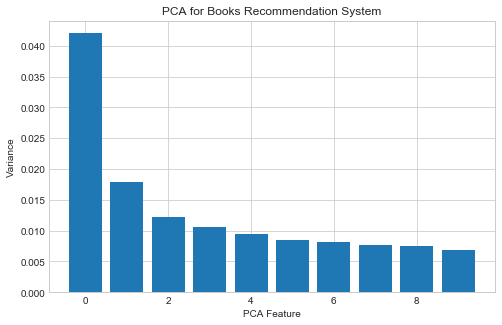

In [12]:
#visulaising the principal components to identify the optimal number of latent features present in the data
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,5))
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Books Recommendation System')
plt.bar(range(0, pca_fit.explained_variance_ratio_.size), pca_fit.explained_variance_ratio_)
plt.show()

From PCA, we can see that there are 3 principle components in the germany user-book ratiing data.

In [13]:
#Converting the dataframe to matrix and normalize the ratings using the user-mean
german_matrix = pivot_table.as_matrix()
user_ratings_mean = np.mean(german_matrix, axis = 1)
german_matrix_demeaned = german_matrix - user_ratings_mean.reshape(-1, 1)

C:\Users\WavicleData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [14]:
U, sigma, Vt = svds(german_matrix_demeaned, k = 3)
sigma = np.diag(sigma)

Predicted user-rating for each book using SVD

In [15]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
user_book_rating = pd.DataFrame(all_user_predicted_ratings, columns = pivot_table.columns,index=pivot_table.index)
user_book_rating

userid,22,242,372,628,736,758,850,899,914,921,...,278280,278302,278551,278644,278665,278720,278721,278729,278731,278778
booktitle,,,,,,,,,,,,,,,,,,,,,
!Yo!,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
' Mein verwundetes Herz'. Das Leben der Lilli Jahn 1900 - 1944.,0.001773,0.001864,0.001774,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,...,0.001773,0.001773,0.001774,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001775
' Sehr geehrtes Arschloch.' Briefe an den RegierungsprÃ?Â¤sidenten.,0.001185,0.001171,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,...,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185,0.001185
"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",0.001779,0.001746,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,...,0.001779,0.001779,0.001778,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001778
' Small g'. Eine Sommeridylle.,0.001108,0.002559,0.001125,0.001109,0.001109,0.001116,0.001102,0.001103,0.001106,0.001109,...,0.001109,0.001110,0.001128,0.001109,0.001109,0.001115,0.001109,0.001109,0.001109,0.001142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ã?Â?berraschung am Valentinstag.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ã?Â?lpiraten.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ã?Â?rger mit Produkt X. Roman.,0.004125,0.004536,0.004130,0.004126,0.004126,0.004128,0.004124,0.004124,0.004125,0.004126,...,0.004126,0.004126,0.004131,0.004126,0.004126,0.004127,0.004126,0.004126,0.004126,0.004135


### Function for providing recommendations using user-item similarity (Cosine Similarity Measure)

In [16]:
def rs(book_name,pivot_table ):
    c = pivot_table.index.values.tolist()
    book_num = c.index(book_name)
    knn = NearestNeighbors(metric="cosine",algorithm="auto")
    knn.fit(pivot_table)
    distances, indices = knn.kneighbors(pivot_table.iloc[book_num, :].values.reshape(1, -1), n_neighbors = 5)
    bookname = pivot_table.index[book_num]
    booktitle = []
    rec_set = []
    rec= pd.DataFrame([rec_set])
    for i in range(0, len(distances.flatten())):        
        if i == 0:
            display(Markdown('**Recommendations for {0}**'.format(bookname)))
        else:
            print('{} '.format(pivot_table.index[indices.flatten()[i]]))

Recommendations Provided:

In [17]:
rs("!Yo!",user_book_rating)

**Recommendations for !Yo!**

Opposites Attract 
Opernball 
Ophelia Lernt Schwimmen 
Operation: Baby (Harlequin American Romance, No 689) 


In [18]:
rs("stardust",user_book_rating)

**Recommendations for stardust**

Je Voudrais Que Quelqu'un M'Attende Quelque Part 
The No. 1 Ladies' Detective Agency (Today Show Book Club #8) 
Girl with a Pearl Earring 
Total Kheops 
